## Load the Data and Set the Path

In [1]:
setwd("~/Desktop/Projects/Global-Preferences-Survey/")
source("ReproductionAnalysis/functions/helper_functions/SourceFunctions.r")
SourceFunctions(path = "ReproductionAnalysis/functions/")
SourceFunctions(path = "ReproductionAnalysis/functions/helper_functions/")
SourceFunctions(path = "ExtendedAnalysis/functions/")

In [2]:
# Load libraries
LoadRequiredLibraries_new()

select <- dplyr::select
melt <- reshape2::melt


Attaching package: ‘data.table’


The following object is masked from ‘package:rlang’:

    :=


Loading required package: bit


Attaching package: ‘bit’


The following object is masked from ‘package:data.table’:

    setattr


The following object is masked from ‘package:base’:

    xor


Attaching package bit64

package:bit64 (c) 2011-2017 Jens Oehlschlaegel

creators: integer64 runif64 seq :

coercion: as.integer64 as.vector as.logical as.integer as.double as.character as.bitstring

logical operator: ! & | xor != == < <= >= >

arithmetic operator: + - * / %/% %% ^

math: sign abs sqrt log log2 log10

math: floor ceiling trunc round

querying: is.integer64 is.vector [is.atomic} [length] format print str

values: is.na is.nan is.finite is.infinite

aggregation: any all min max range sum prod

cumulation: diff cummin cummax cumsum cumprod

access: length<- [ [<- [[ [[<-

combine: c rep cbind rbind as.data.frame

WARNING don't use as subscripts

WARNING semantics differ from integer



In [12]:
# Load the data
data_all <- LoadData()

## Data Preparation

In [13]:
data_all <- PrepareData(data_all)

# Standardize preferences at country level
data_all$data <- Standardize(data    = data_all$data,
                             columns = c(5:10),
                             level   = "country")

# Use only the complete dataset
dataComplete <- data_all$data[complete.cases(data_all$data)]

### Create the models

In [14]:
# Model on country level of the preferences
models <- CreateModelsForPreferencesCountryLevel_robust(dataComplete)

# Summarize the preferences for each country
dataCoeff <- SummaryCoeffPerPreferencePerCountry(models)

# Add important column
dataComplete[, logAvgGDPpc := log(avgGDPpc), by = "country"]
dataComplete[, avgGDPpc := NULL]

In [15]:
setnames(dataCoeff, old = "gender1", new = "gender")

## Model Analysis and Diagnostic

In [21]:
# Create the column age squared
dataComplete[, age_2 := age^2]
# Use gender as a factor and not as numeric
dataComplete[, gender := as.factor(gender)]
# Select the interesting columns
colsVar <- c("country", names(dataComplete)[5:13], "age_2")
# Select the data to fit
dataToFit <- dataComplete %>% select(all_of(colsVar))
# Create a model for each preference
preferences <- names(dataToFit)[2:7]

models <- lapply(preferences, function(x) {
    form <- paste0(x, " ~ gender + age + age_2 + subj_math_skills")
    model <- dlply(dataToFit, "country", function(dt)
      lm(eval(as.formula(form)), data = dt))
  })

In [27]:
names(models) <- preferences

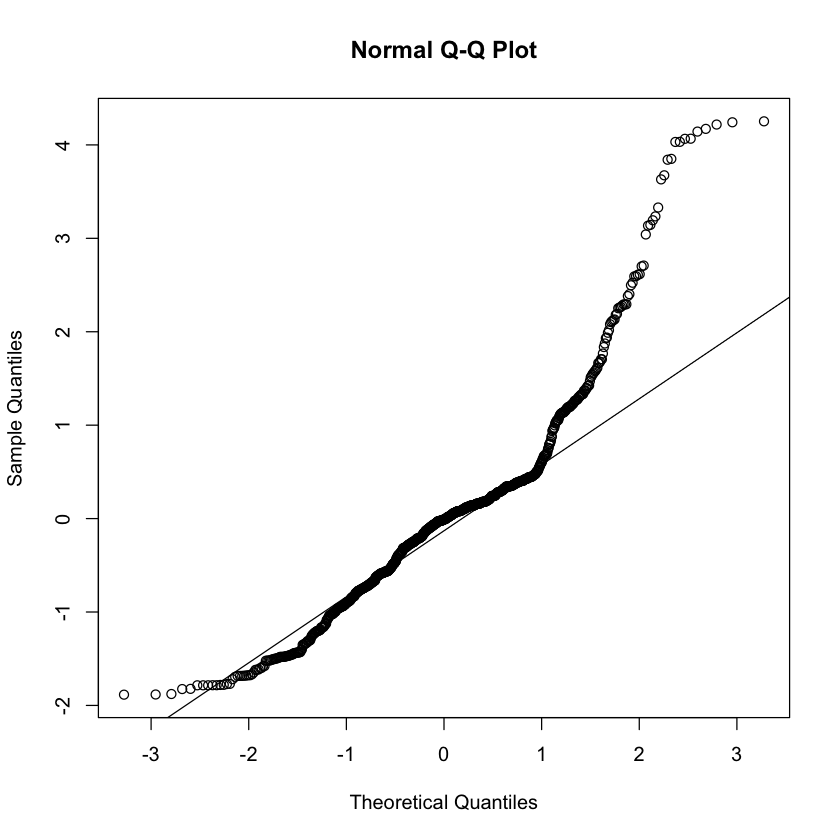

In [48]:
qqnorm(models[["patience"]][["Afghanistan"]]$residuals)
qqline(models[["patience"]][["Afghanistan"]]$residuals)

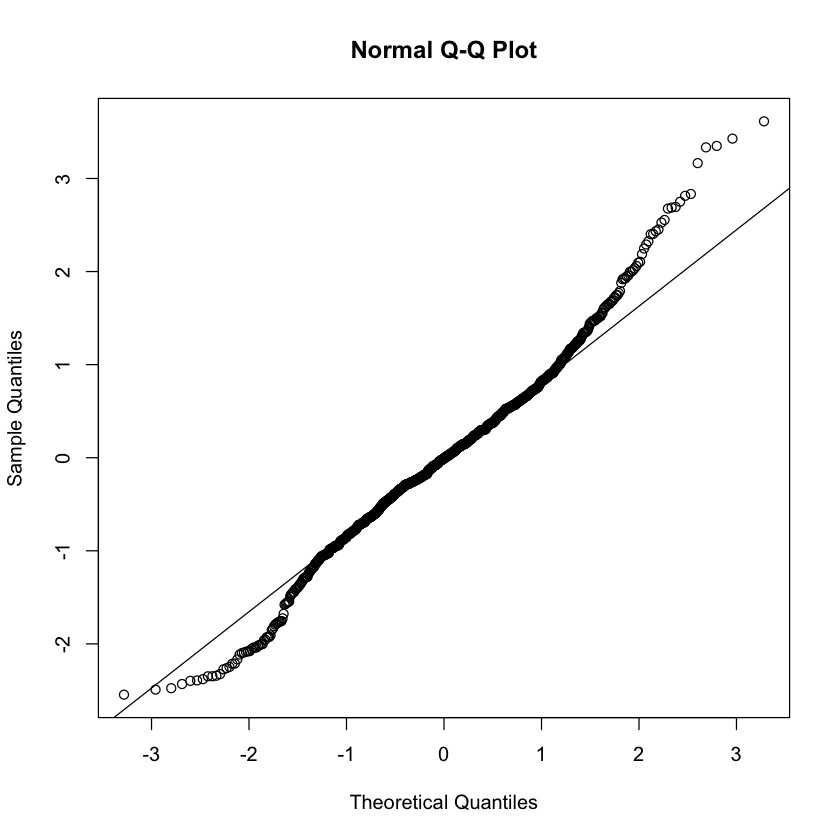

In [49]:
qqnorm(models[["risktaking"]][["Italy"]]$residuals)
qqline(models[["risktaking"]][["Italy"]]$residuals)

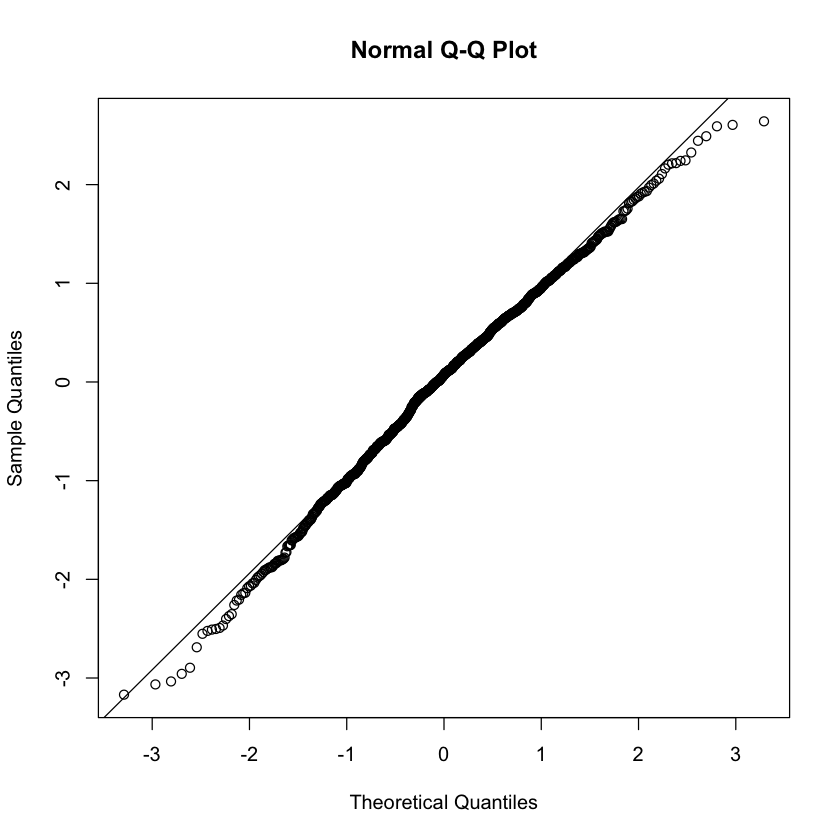

In [50]:
qqnorm(models[["altruism"]][["Ghana"]]$residuals)
qqline(models[["altruism"]][["Ghana"]]$residuals)

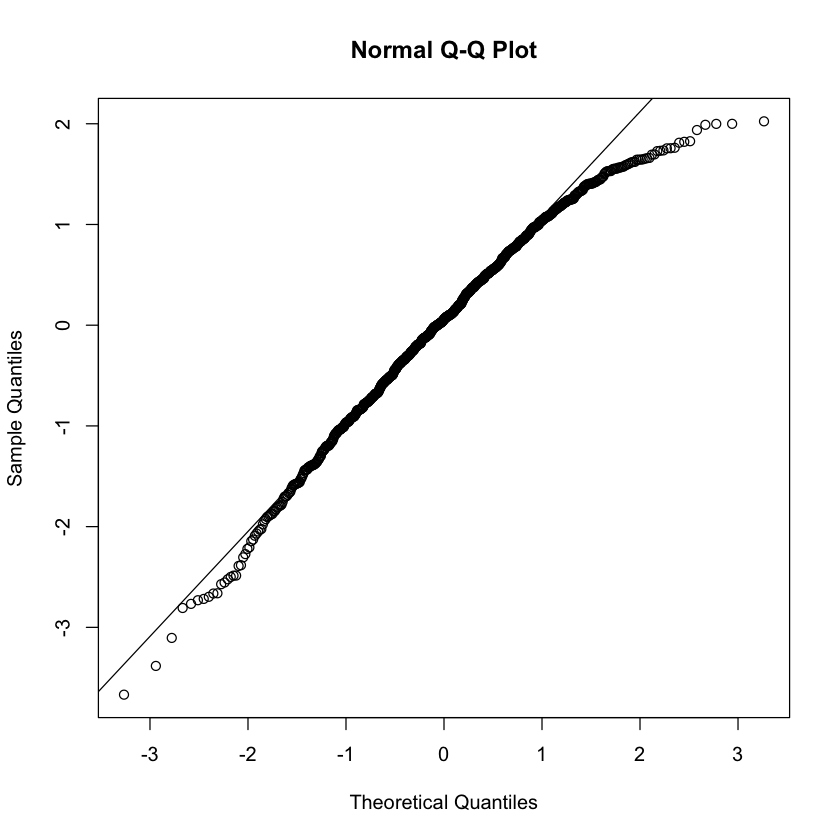

In [51]:
qqnorm(models[["posrecip"]][["Peru"]]$residuals)
qqline(models[["posrecip"]][["Peru"]]$residuals)

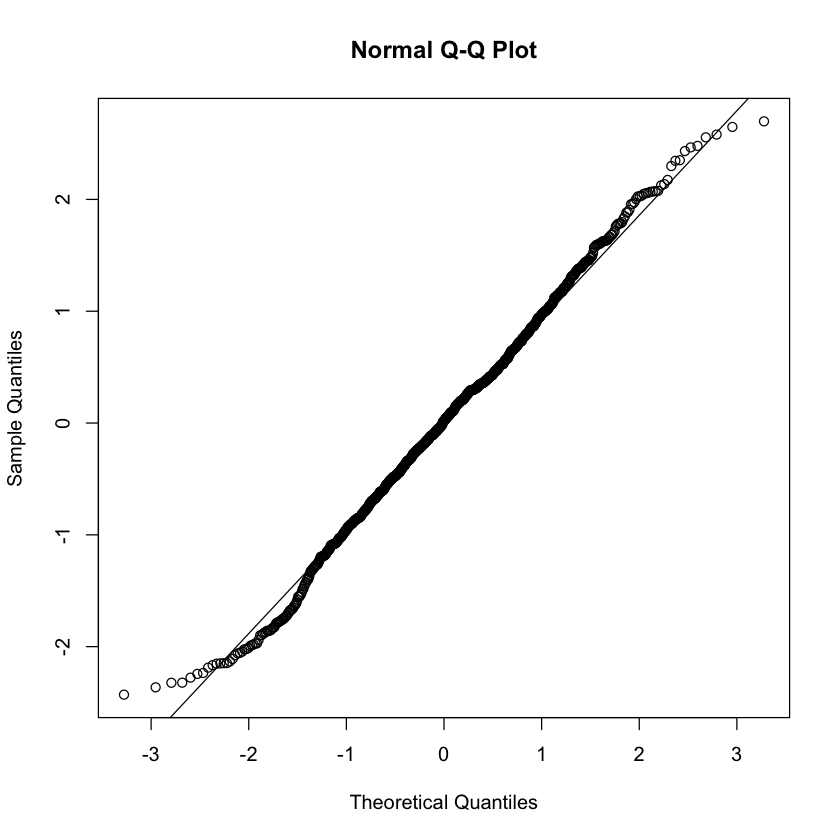

In [52]:
qqnorm(models[["negrecip"]][["Japan"]]$residuals)
qqline(models[["negrecip"]][["Japan"]]$residuals)

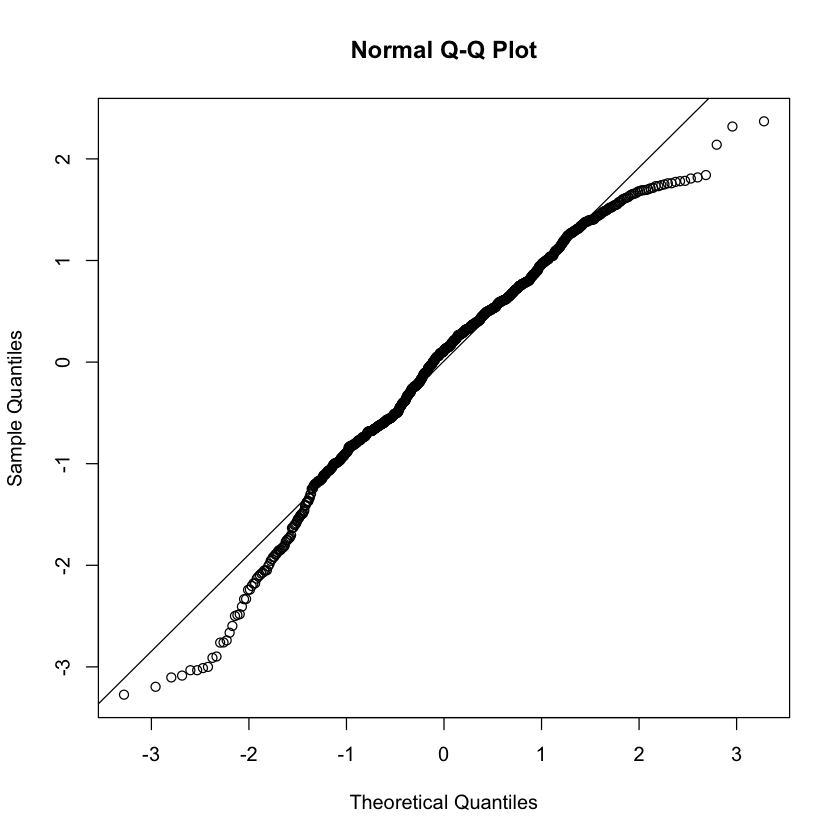

In [53]:
qqnorm(models[["trust"]][["Australia"]]$residuals)
qqline(models[["trust"]][["Australia"]]$residuals)

### PCA of gender differences

In [10]:
# PCA on the preferences
summaryIndex <- AvgGenderDiffPreferencesPCA(dataCoeff)
# Prepare summary index
summaryIndex <- CreateSummaryIndex(summaryIndex, data_all)

-----

## Model analysis

What does influences the most the results?

In [ ]:
# Intercept only
model_trust <- dlply(dataComplete, "country", function(dt)
  lm(trust ~ 1, data = dt))
model_risktaking <- dlply(dataComplete, "country", function(dt)
  lm(risktaking ~ 1, data = dt))
model_altruism <- dlply(dataComplete, "country", function(dt)
  lm(altruism ~ 1, data = dt))
model_posrecip <- dlply(dataComplete, "country", function(dt)
  lm(posrecip ~ 1, data = dt))
model_negrecip <- dlply(dataComplete, "country", function(dt)
  lm(negrecip ~ 1, data = dt))
model_patience <- dlply(dataComplete, "country", function(dt)
  lm(patience ~ 1, data = dt))

In [ ]:
# Intercept + gender
modelG_trust <- dlply(dataComplete, "country", function(dt)
  lm(trust ~ gender, data = dt))
modelG_risktaking <- dlply(dataComplete, "country", function(dt)
  lm(risktaking ~ gender, data = dt))
modelG_altruism <- dlply(dataComplete, "country", function(dt)
  lm(altruism ~ gender, data = dt))
modelG_posrecip <- dlply(dataComplete, "country", function(dt)
  lm(posrecip ~ gender, data = dt))
modelG_negrecip <- dlply(dataComplete, "country", function(dt)
  lm(negrecip ~ gender, data = dt))
modelG_patience <- dlply(dataComplete, "country", function(dt)
  lm(patience ~ gender, data = dt))

In [ ]:
AIC_altruism <- Map(function(model_altruism, modelG_altruism) 
    anova(model_altruism, modelG_altruism), 
    model_altruism, modelG_altruism)

In [ ]:
print(AIC_altruism)

In [ ]:
modelALL_risktaking <- dlply(dataComplete, "country", function(dt)
  lm(risktaking ~ gender + subj_math_skills + age, data = dt))

In [ ]:
Map(function(model) drop1(model, test = "F"), modelALL_risktaking)

In [ ]:
plot(modelALL_risktaking[["Iran"]])

In [ ]:
dataComplete[country == "Italy" & (cooks.distance(modelALL_risktaking[["Italy"]]) > 0.015)]

In [ ]:
ggplot(dataComplete[country == "Canada"]) +
geom_histogram(aes(x = patience, fill = gender), position = "dodge")

In [ ]:
library(MASS)

In [ ]:
model <- dlply(dataComplete, "country", function(dt) polr(trustRaw ~ age + gender + subj_math_skills, data = dt, Hess = TRUE))

In [ ]:
all_countries <- c()

for (c in unique(dataComplete$country)) {
    model <- polr(trustRaw ~ age + gender + subj_math_skills, data = dataComplete[country == c])
    coeff <- step(model)$coefficient
    dt_coeff <- data.table(country = rep(c, length(coeff)),
                           coefficients = coeff,
                           names_coeff = names(coeff))
    all_countries <- rbind(all_countries, dt_coeff)
}



In [ ]:
head(all_countries)

In [ ]:
ggplot(all_countries) +
geom_point(aes(x = country, y = coefficients)) +
facet_wrap(~ names_coeff)

In [ ]:
all_countries[names_coeff == "gender1", .N]

In [ ]:
all_countries[names_coeff == "subj_math_skills", .N]

In [ ]:
all_countries[names_coeff == "age", .N]

In [ ]:
ggplot(all_countries[names_coeff == "gender1"]) +
geom_point(aes(x = country, y = coefficients))